In [66]:
import sys
import os
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd

# Get the parent folder path (folder K)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(parent_folder)

# Add folder A to the Python path
folder_classes_path = os.path.join(parent_folder, 'classes')
sys.path.append(folder_classes_path)

from true_WB import *
from input_generate_plugin import *
from entropic_estimate_OT import *
from entropic_iterative_scheme import *
from config_log import *
from measure_visualize import *
from input_generate_entropy import *
from sample_plot import *

/Users/zeyichen/Github/Repo/WB_Algo/Stochastic_FP


# DIM = 10

In [26]:
dim = 10
num_samples = 5000
num_measures = 10
iter = 0
truncated_radius = 5000
seed = 1009

In [27]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.random_components(num_components=5, uniform_weights = True, seed = seed) # seed from the measure selection
# source_sampler.set_truncation(truncated_radius)

In [28]:
auxiliary_measure_sampler_set = []
for auxiliary_seed in range(10):
    auxiliary_measure_sampler = MixtureOfGaussians(dim)
    auxiliary_measure_sampler.random_components(num_components=5, uniform_weights = True, seed = auxiliary_seed * 100)
    # auxiliary_measure_sampler.set_truncation(truncated_radius)
    auxiliary_measure_sampler_set.append(auxiliary_measure_sampler)

In [29]:
# construct entropic_sampler
entropic_sampler = entropic_input_sampler(dim, 
                                          num_measures, 
                                          auxiliary_measure_sampler_set, 
                                          source_sampler = source_sampler, 
                                          n_k = 1000, 
                                          seed = 120, 
                                          gamma = 0.3, 
                                          manual = False,
                                          truncated_radius = truncated_radius,
                                          bound_type = "norm_bound")


In [30]:
result_path = "./results/entropic_measures_10_seed_1009_samples_5000_dim_10_epsilon_10"

In [31]:
# Load the sampler attributes
with open(f"{result_path}/entropic_sampler_info.pkl", "rb") as f:
    loaded_data_entropic_sampler = pickle.load(f)

with open(f"{result_path}/source_sampler_info.pkl", "rb") as f:
    loaded_data_source_sampler = pickle.load(f)

print("Loaded Data for Entropic Sampler:", loaded_data_entropic_sampler)
print("Loaded Data for Source Sampler:", loaded_data_source_sampler)

Loaded Data for Entropic Sampler: {'dim': 10, 'num_measures': 10, 'auxiliary_measure_sampler_set': [<true_WB.MixtureOfGaussians object at 0x17d733d90>, <true_WB.MixtureOfGaussians object at 0x182770e90>, <true_WB.MixtureOfGaussians object at 0x1c435c0d0>, <true_WB.MixtureOfGaussians object at 0x185625850>, <true_WB.MixtureOfGaussians object at 0x1817e7910>, <true_WB.MixtureOfGaussians object at 0x1cfdf7550>, <true_WB.MixtureOfGaussians object at 0x180847dd0>, <true_WB.MixtureOfGaussians object at 0x180844d50>, <true_WB.MixtureOfGaussians object at 0x1cfde1210>, <true_WB.MixtureOfGaussians object at 0x1cfde2090>], 'tilde_K': 10, 'source_sampler': <true_WB.MixtureOfGaussians object at 0x1cfde0a10>, 'n_k': 1000, 'seed': 120, 'rng_entropy': RandomState(MT19937) at 0x1807DD440, 'gamma': 0.3, 'manual': False, 'truncated_radius': 5000, 'bound_type': 'norm_bound', 'grid_size': 200, 'strong_convexity_param_dict': {0: 0.0001, 1: 0.0001, 2: 0.0001, 3: 0.0001, 4: 0.0001, 5: 0.0001, 6: 0.0001, 7: 0

In [32]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.__dict__.update(loaded_data_source_sampler)

entropic_sampler = entropic_input_sampler(dim, num_measures, auxiliary_measure_sampler_set, source_sampler = source_sampler, n_k = 1000, seed = 120)
entropic_sampler.__dict__.update(loaded_data_entropic_sampler)

## Plot: V_value and W2_to_true_bary

In [33]:
# load the G_samples from result_path
with open(f"{result_path}/G_samples/G_samples.json", "r") as G_samples_file:
    G_samples = json.load(G_samples_file)

num_iterations = len(G_samples)
num_MCsamples = len(G_samples['iteration_0'])
# print the key of the dictionary
print(num_iterations, num_MCsamples, len(G_samples['iteration_0']['0']))
G_samples['iteration_0']['0'][0]

20 20 5000


[-1.6776948352123395,
 -1.6211347969290706,
 0.4592557722378876,
 -0.7347113458895279,
 -1.2339949423230006,
 -1.1361881526036541,
 0.8848541808145827,
 -0.036529797633390454,
 -1.3840648435734184,
 0.913398887296186]

In [34]:
def W2_pot(X, Y): # solving the OT simplex problem using POT package
    M = ot.dist(X, Y)
    a, b = np.ones((X.shape[0],)) / X.shape[0], np.ones((Y.shape[0],)) / Y.shape[0]
    W2_sq = ot.emd2(a, b, M, numItermax=1e6)
    return W2_sq

def V_value_compute(bary_samples, input_sample_collection):
    # Compute the V-value (i.e.,\@ the weighted sum of the Wasserstein distances between the input measures and the generated samples)
    # Notice that when iter = None, this returns the true V_value given by the ground-truth barycenter;
    # Otherwise, it is the V_value returned by an approximated barycenter.
    # The input_sample_collection is a dictionary with k keys, each key corresponds to the samples from the k-th input measure.

    V_value = 0
    num_measures = len(input_sample_collection)
    for measure_index in range(num_measures):
        input_samples = np.array(input_sample_collection[measure_index])
        V_value += W2_pot(input_samples, bary_samples)
    V_value = V_value / num_measures
    return V_value


In [35]:
V_value_dir = f"{result_path}/V_values"
W2_to_true_dirc = f"{result_path}/W2_to_true_bary"

In [36]:
csv_dirc = f"{result_path}/input_and_source_samples/csv_files"
os.path.exists(csv_dirc)

True

In [ ]:
########################## FREEZE THE CODE HERE ########################################
# Iterate over the iterations and the MC samples therein
for iter in range(10):
    print(f"Iteration {iter}")
    G_samples_iter = G_samples[f'iteration_{iter}']
    V_values_MC = []
    W2_to_true_MC = []
    for MCsample in tqdm(range(num_MCsamples)):
        G_samples_MCsample = np.array(G_samples_iter[f'{MCsample}'])
        V_value = 0
        for measure_index in range(num_measures):
            input_measure_samples = pd.read_csv(f"{csv_dirc}/input_measure_samples_{measure_index}.csv", header = None)
            input_samples = np.array(input_measure_samples)
            input_samples = input_samples[np.random.choice(input_samples.shape[0], size=num_samples, replace=False)]
            V_value += W2_pot(input_samples, G_samples_MCsample)
        # normalize the V_value by the number of input measures
        V_value /= num_measures
        V_values_MC.append(V_value)

        bary_samples = pd.read_csv(f"{csv_dirc}/true_barycenter_samples.csv", header = None)
        bary_samples = np.array(bary_samples)
        bary_samples = bary_samples[np.random.choice(bary_samples.shape[0], size=num_samples, replace=False)]
        W2_to_true_MC.append(W2_pot(bary_samples, G_samples_MCsample))
    # Save the V_values and W2_to_true
    with open(f"{V_value_dir}/V_values_iter_{iter}.pkl", "wb") as V_values_file:
        pickle.dump(V_values_MC, V_values_file)
    with open(f"{W2_to_true_dirc}/W2_to_true_iter_{iter}.pkl", "wb") as W2_to_true_file:
        pickle.dump(W2_to_true_MC, W2_to_true_file)

Iteration 0


100%|██████████| 20/20 [18:36<00:00, 55.84s/it]


Iteration 1


100%|██████████| 20/20 [12:53<00:00, 38.67s/it]


Iteration 2


100%|██████████| 20/20 [12:00<00:00, 36.01s/it]


Iteration 3


100%|██████████| 20/20 [11:42<00:00, 35.11s/it]


Iteration 4


100%|██████████| 20/20 [11:23<00:00, 34.17s/it]


Iteration 5


100%|██████████| 20/20 [11:25<00:00, 34.26s/it]


Iteration 6


100%|██████████| 20/20 [11:32<00:00, 34.65s/it]


Iteration 7


100%|██████████| 20/20 [11:22<00:00, 34.11s/it]


Iteration 8


100%|██████████| 20/20 [11:27<00:00, 34.39s/it]


Iteration 9


100%|██████████| 20/20 [11:25<00:00, 34.28s/it]


In [ ]:
with open(f"{result_path}/true_V_values_dim10.pkl", "rb") as f:
    true_v_value_record_dim10 = np.array(pickle.load(f)[:20])
# Calculate statistics for true_V_values
trim_pct = 0.1
k = int(len(true_v_value_record_dim10) * trim_pct)
true_v_value_record_dim10_sorted = np.sort(true_v_value_record_dim10)
true_v_value_record_dim10_trimmed = true_v_value_record_dim10_sorted[k:-k]
mean_true_V_dim10 = np.mean(true_v_value_record_dim10_trimmed)
lb_dim10, ub_dim10 = np.quantile(true_v_value_record_dim10_trimmed, [0.25, 0.75])
print(f"True V value: {mean_true_V_dim10} [{lb_dim10}, {ub_dim10}]")

True V value: 8967.693736476866 [8932.524685303866, 9010.39214329197]


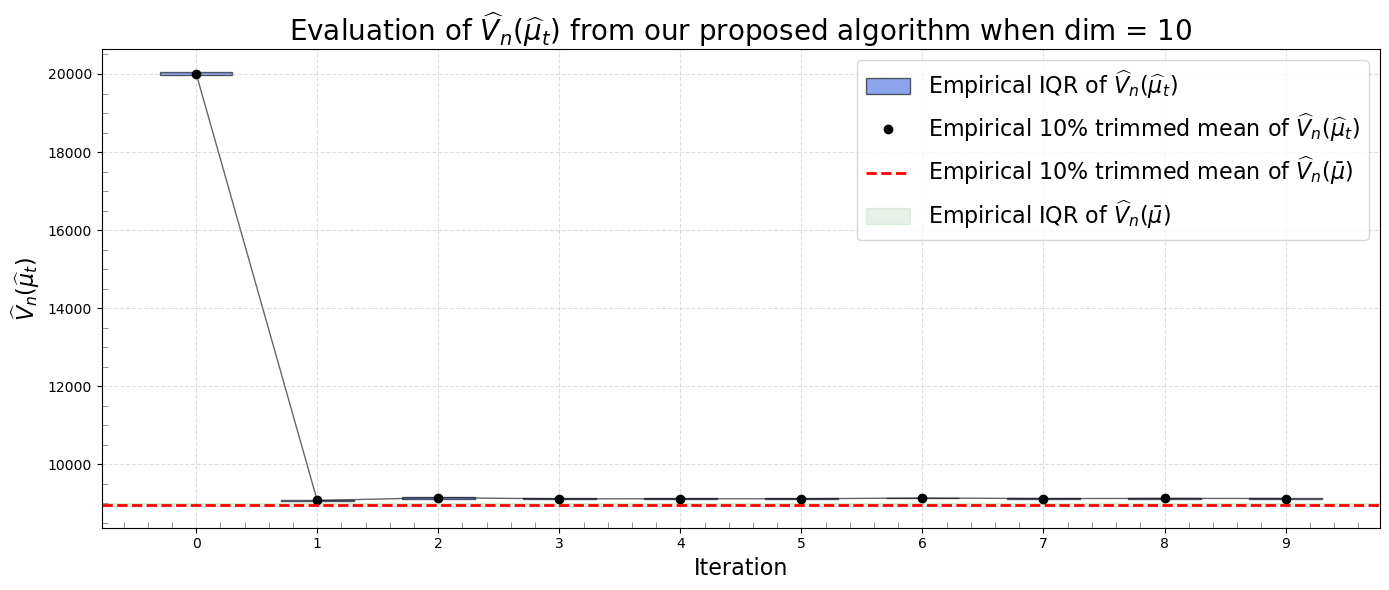

In [67]:
trim_pct = 0.1

plt.figure(figsize=(14, 6))
trimmed_means = []

for iter in range(10):
    with open(f"{V_value_dir}/V_values_iter_{iter}.pkl", "rb") as V_values_file:
        V_values_iter = pickle.load(V_values_file)
    n = len(V_values_iter)
    k = int(n * trim_pct)
    sorted_vals = np.sort(V_values_iter)
    trimmed_vals = sorted_vals[k:-k] if k > 0 else sorted_vals

    # Stats
    trimmed_mean = np.mean(trimmed_vals)
    lower_quantile = np.quantile(trimmed_vals, 0.25)
    upper_quantile = np.quantile(trimmed_vals, 0.75)
    min_val = np.min(trimmed_vals)
    max_val = np.max(trimmed_vals)

    box_width = 0.6

    # Draw "whiskers" from min to max
    plt.plot([iter, iter], [min_val, max_val], color='black', linewidth=1)

    # Only label the first box so legend doesn't repeat
    label = r'Empirical IQR of $\widehat{V}_n(\widehat{\mu}_t)$' if iter == 0 else None

    plt.fill_between([iter - box_width/2, iter + box_width/2],
                    lower_quantile, upper_quantile,
                    color='royalblue', alpha=0.6,
                    edgecolor='black', linewidth=1,
                    label=label)

    # Draw trimmed mean
    plt.plot(iter, trimmed_mean, 'o', color='black', markersize=6, label=r'Empirical 10% trimmed mean of $\widehat{V}_n(\widehat{\mu}_t)$' if iter == 0 else "")
    trimmed_means.append(trimmed_mean)

# Draw true V value
# plt.ylim(bottom = 8500, top=11000)
plt.axhline(mean_true_V_dim10, color='red', linestyle='--', linewidth=2, label=r'Empirical 10% trimmed mean of $\widehat{V}_n(\bar{\mu})$')
plt.plot(range(10), trimmed_means,
         color='black', linestyle='-', linewidth=1, alpha=0.6, zorder=0)
plt.axhspan(lb_dim10, ub_dim10, color='green', alpha=0.1, label=r'Empirical IQR of $\widehat{V}_n(\bar{\mu})$')
plt.xticks(ticks=range(10), labels=range(10))

# Add minor ticks
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='minor', length=4, color='gray', direction='in')

plt.grid(True, linestyle='--', alpha=0.4)


plt.xlabel('Iteration', fontsize=16)
plt.ylabel(r"$\widehat{V}_n(\widehat{\mu}_t)$", fontsize=16)
plt.title(r"Evaluation of $\widehat{V}_n(\widehat{\mu}_t)$ from our proposed algorithm when dim = 10", fontsize=20)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.savefig(f"{result_path}/V_values_convergence_SFP.png")
plt.show()


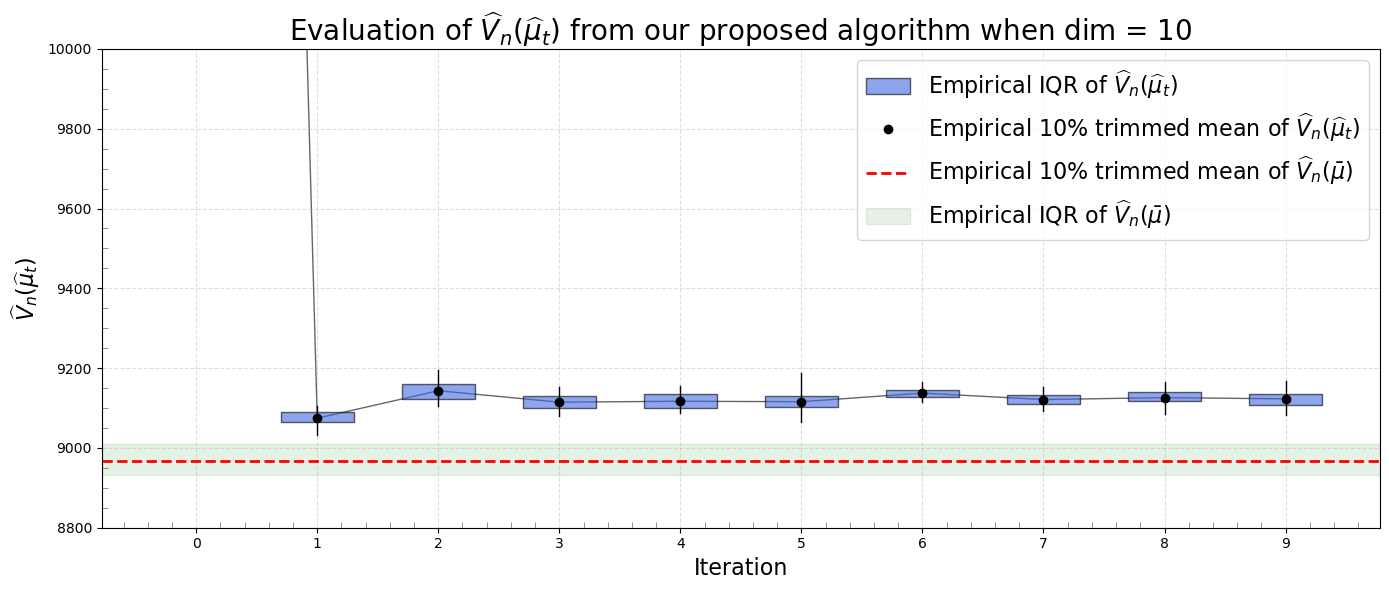

In [68]:
trim_pct = 0.1

plt.figure(figsize=(14, 6))
trimmed_means = []

for iter in range(10):
    with open(f"{V_value_dir}/V_values_iter_{iter}.pkl", "rb") as V_values_file:
        V_values_iter = pickle.load(V_values_file)
    n = len(V_values_iter)
    k = int(n * trim_pct)
    sorted_vals = np.sort(V_values_iter)
    trimmed_vals = sorted_vals[k:-k] if k > 0 else sorted_vals

    # Stats
    trimmed_mean = np.mean(trimmed_vals)
    lower_quantile = np.quantile(trimmed_vals, 0.25)
    upper_quantile = np.quantile(trimmed_vals, 0.75)
    min_val = np.min(trimmed_vals)
    max_val = np.max(trimmed_vals)

    box_width = 0.6

    # Draw "whiskers" from min to max
    plt.plot([iter, iter], [min_val, max_val], color='black', linewidth=1)

    # Only label the first box so legend doesn't repeat
    label = r'Empirical IQR of $\widehat{V}_n(\widehat{\mu}_t)$' if iter == 0 else None

    plt.fill_between([iter - box_width/2, iter + box_width/2],
                    lower_quantile, upper_quantile,
                    color='royalblue', alpha=0.6,
                    edgecolor='black', linewidth=1,
                    label=label)

    # Draw trimmed mean
    plt.plot(iter, trimmed_mean, 'o', color='black', markersize=6, label=r'Empirical 10% trimmed mean of $\widehat{V}_n(\widehat{\mu}_t)$' if iter == 0 else "")
    trimmed_means.append(trimmed_mean)

# Draw true V value
# plt.ylim(bottom = 8500, top=11000)
plt.ylim(8800, 10000)
plt.axhline(mean_true_V_dim10, color='red', linestyle='--', linewidth=2, label=r'Empirical 10% trimmed mean of $\widehat{V}_n(\bar{\mu})$')
plt.plot(range(10), trimmed_means,
         color='black', linestyle='-', linewidth=1, alpha=0.6, zorder=0)
plt.axhspan(lb_dim10, ub_dim10, color='green', alpha=0.1, label=r'Empirical IQR of $\widehat{V}_n(\bar{\mu})$')
plt.xticks(ticks=range(10), labels=range(10))

# Add minor ticks
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='minor', length=4, color='gray', direction='in')

plt.grid(True, linestyle='--', alpha=0.4)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel(r"$\widehat{V}_n(\widehat{\mu}_t)$", fontsize=16)
plt.title(r"Evaluation of $\widehat{V}_n(\widehat{\mu}_t)$ from our proposed algorithm when dim = 10", fontsize=20)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.savefig(f"{result_path}/V_values_convergence_SFP.png")
plt.show()


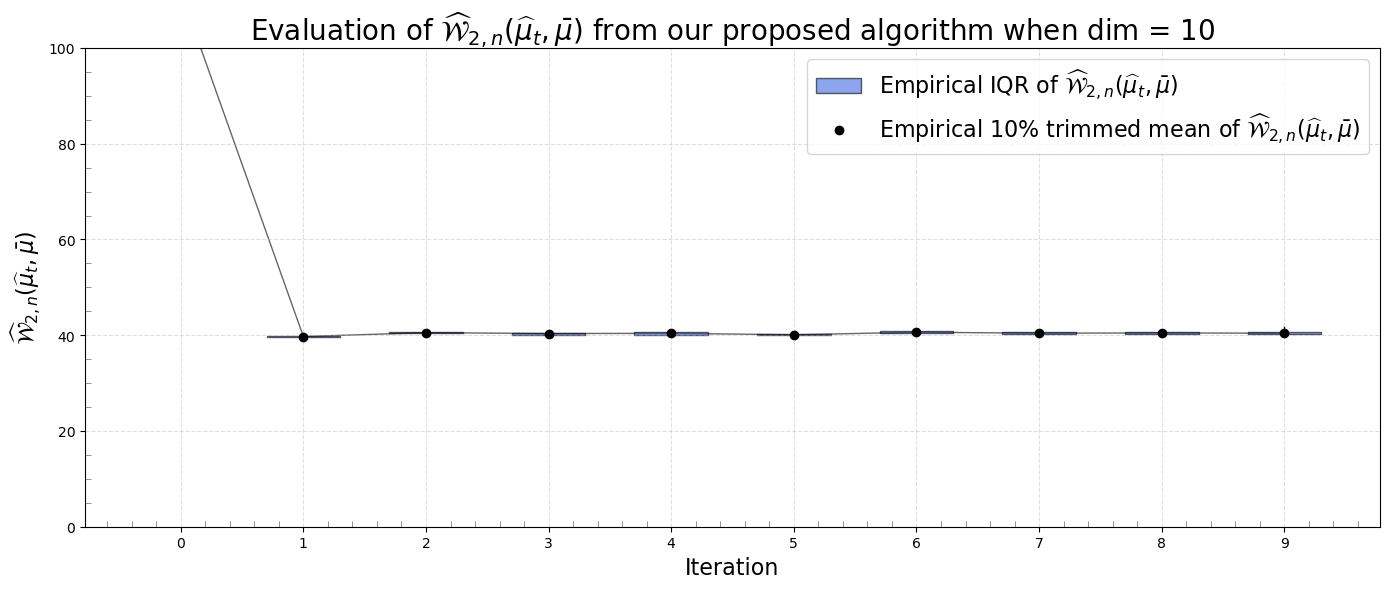

In [74]:
trim_pct = 0.1

plt.figure(figsize=(14, 6))
trimmed_means = []
all_values = []

for iter in range(10):
    with open(f"{W2_to_true_dirc}/W2_to_true_iter_{iter}.pkl", "rb") as W2_to_true_file:
        W2_to_true_iter = pickle.load(W2_to_true_file)
    W2_to_true_iter = np.sqrt(W2_to_true_iter)
    n = len(W2_to_true_iter)
    k = int(n * trim_pct)
    sorted_vals = np.sort(W2_to_true_iter)
    trimmed_vals = sorted_vals[k:-k] if k > 0 else sorted_vals

    # Stats
    trimmed_mean = np.mean(trimmed_vals)
    lower_quantile = np.quantile(trimmed_vals, 0.25)
    upper_quantile = np.quantile(trimmed_vals, 0.75)
    min_val = np.min(trimmed_vals)
    max_val = np.max(trimmed_vals)
    all_values.append(trimmed_vals)

    box_width = 0.6

    # Draw "whiskers" from min to max
    plt.plot([iter, iter], [min_val, max_val], color='black', linewidth=1)

    # Only label the first box so legend doesn't repeat
    label = r'Empirical IQR of $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$' if iter == 0 else None

    plt.fill_between([iter - box_width/2, iter + box_width/2],
                    lower_quantile, upper_quantile,
                    color='royalblue', alpha=0.6,
                    edgecolor='black', linewidth=1,
                    label=label)

    # Draw trimmed mean
    plt.plot(iter, trimmed_mean, 'o', color='black', markersize=6, label=r'Empirical 10% trimmed mean of $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$' if iter == 0 else "")
    trimmed_means.append(trimmed_mean)

min_achieved = np.min([np.min(vals) for vals in all_values])
# Draw true V value
# plt.axhline(mean_true_V_dim2, color='red', linestyle='--', linewidth=2, label='True V Value')
# plt.axhline(min_achieved, color='red', linestyle='--', linewidth=2,
#             label=r'Minimum $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})^2$ across epochs')
# # Add a label (adjust x-position if needed)
# plt.text(0, min_achieved,
#          f"{min_achieved:.2f}",  # format to 2 decimals
#          color='red', fontsize=10, va='bottom')
plt.ylim(bottom = 0, top=100)
plt.plot(range(10), trimmed_means,
         color='black', linestyle='-', linewidth=1, alpha=0.6, zorder=0)
# plt.axhspan(lb_dim2, ub_dim2, color='green', alpha=0.1, label=r'Empirical 90% central interval of $\widehat{V}_n(\bar{\mu})$')
plt.xticks(ticks=range(10), labels=range(10))

# Add minor ticks
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='minor', length=4, color='gray', direction='in')

plt.grid(True, linestyle='--', alpha=0.4)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel(r"$\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$", fontsize=16)
plt.title(r"Evaluation of $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$ from our proposed algorithm when dim = 10", fontsize=20)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.savefig(f"{result_path}/W2_to_true_convergence_SFP.png")
plt.show()
